# Introdução às Redes Neurais Fisicamente Informadas - PINNs (Dia 05) Picture1.jpg

---
**EXEMPLO 3**

**Objetivo:** resolver a equação da onda unidimensional $$u_t-u_x=0$$
com condição inicial $u(0,x)=1-x^2,$ se $x\in[-1,1]$ e $u(0,t)=0$, se $x\in[-2,-1)\cup(1,2].$ Vamos calcular e apresentar a solução numérica no domínio $D=\{(t,x)\in\mathbb{R}^2\,:\,t\in[0,1],\,x\in[-2,2]\}.$

Para esse problema a solução exata é conhecida e é dada por uma onda viajante na forma $$u(t,x)=u(0,x+t).$$

Vamos novamente resolver o problema utilizando o `tensorflow`.



---
Começamos importando as bibliotecas necessárias e aqui usaremos o TensorFlow 2.0/Keras

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

---
Agora fixamos a semente, para que as soluções possam ser reproduzidas.

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

---
Definindo agora alguns parâmetros do problema:

* Domínio temporal-espacial $D=[0,1]\times[-2,2]$;
* Condição inicial $u(0,x)=1-x^2,$ se $x\in[-1,1]$ e $u(0,t)=0$, se $x\in[-2,-1)\cup(1,2]$;
* Solução analítica $u(t,x)=u(0,x+t).$

In [ ]:
x_min, x_max = -2, 2
t_min, t_max = 0, 1

# condição inicial
def initial_condition(x):
    return np.where(np.abs(x) <= 1, 1 - x**2, 0)

# solução analítica
def analytical_solution(t, x):
    return np.where(np.abs(x+t) <= 1, 1 - (x+t)**2, 0)

---
Criamos agora o nosso modelo: uma rede neural com 4 camadas escondidas com 80 neurônios em cada. A função de ativação escolhida é a tangente hiperbólica. Perceba que na entrada recebemos um vetor de 2 dimensões e retornamos na saída 1 número.

In [ ]:
def create_model():
    initializer = tf.keras.initializers.GlorotNormal() # inicialização dos pesos
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)), # entrada
        tf.keras.layers.Dense(80, activation='tanh'),
        tf.keras.layers.Dense(80, activation='tanh'),
        tf.keras.layers.Dense(80, activation='tanh'),
        tf.keras.layers.Dense(80, activation='tanh'),
        tf.keras.layers.Dense(1, activation=None) # saída
    ])
    return model

---
Vamos definir a seguir a função de perda do nosso problema. Definimos inicialmente a perda apenas da EDP e, em seguida, definimos a perda total, incluindo a condição inicial.

A função de perda particular para o nosso problema será dividida em duas partes. A função de perda da EDP: $$L_{\text{odp}}=\frac{1}{n}\sum_{i=1}^{n}\left(\frac{\partial NN(t_{i},x_{i})}{\partial t}-\frac{\partial NN(t_{i},x_{i})}{\partial x}\right)^{2}.$$
E a função de perda da condição inicial: $$L_{\text{ic}}=\frac{1}{m}\sum_{i=1}^{m}\left(NN(0,x_i)-u(0,x_i)\right)^{2}$$
Função de perda total: $$L_{\text{Total}}=L_{\text{ode}}+L_{\text{ic}}.$$

In [ ]:
# parte da função de perda que corresponde a edp
def loss_function(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u = model(tf.concat([t, x], axis=1))
        u_t = tape.gradient(u, t)
        u_x = tape.gradient(u, x)
    residual = u_t - u_x
    return tf.reduce_mean(tf.square(residual))

# função de perda total
def total_loss(model, x, t, x_ic, u_ic):
    loss_phys = loss_function(model, x, t)
    u_pred = model(tf.concat([tf.zeros_like(x_ic), x_ic], axis=1))
    loss_ic = tf.reduce_mean(tf.square(u_ic - u_pred))
    return loss_phys + loss_ic

---
Definimos a função que fará o treino do modelo, isto é, a função que atualizará os gradientes de acordo com otimizador escolhido. Neste caso o otimizador escolhido foi o ADAM.

In [ ]:
def train_model(model, epochs, x, t, x_ic, u_ic):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = total_loss(model, x, t, x_ic, u_ic)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        if epoch % 1000 == 0:
            print(f'Época {epoch}, Perda: {loss.numpy()}')

---
Já estamos perto da etapa de treinamento e por isso vamos amostrar aleatoriamente os pontos no nosso domínio $[0,1]\times [-2,2].$

In [ ]:
x_train = (np.random.rand(100)*2*x_max+x_min).reshape(-1, 1) # amostra os pontos no intervalo [-2,2]
t_train = (np.random.rand(100)*t_max+t_min).reshape(-1, 1) # amostra os pontos no intervalo [0,1]
x_train, t_train = np.meshgrid(x_train, t_train) # cria uma grade de pontos
x_train = x_train.flatten().reshape(-1, 1)
t_train = t_train.flatten().reshape(-1, 1)

x_ic = (np.random.rand(200)*2*x_max+x_min).reshape(-1, 1) # amostra os pontos no intervalo [-2,2] para a condição inicial apenas
u_ic = initial_condition(x_ic) # calcula a condição inicial nos pontos amostrados

---
Finalmente, vamos treinar o nosso modelo com 8000 épocas.

Perceba que aqui há um cuidado para converter os vetores do `numpy` para o `tensorflow`. Caso isso não seja feito o código dá erro.

In [ ]:
model = create_model()
train_model(model, epochs=8000, x=tf.convert_to_tensor(x_train, dtype=tf.float32),
            t=tf.convert_to_tensor(t_train, dtype=tf.float32),
            x_ic=tf.convert_to_tensor(x_ic, dtype=tf.float32),
            u_ic=tf.convert_to_tensor(u_ic, dtype=tf.float32))

Época 0, Perca: 0.37306198477745056
Época 1000, Perca: 0.0004004350339528173
Época 2000, Perca: 7.949434075271711e-05
Época 3000, Perca: 4.260402420186438e-05
Época 4000, Perca: 2.7213980501983315e-05
Época 5000, Perca: 1.8052280211122707e-05
Época 6000, Perca: 1.4031505088496488e-05
Época 7000, Perca: 1.2097178114345297e-05


---
Depois de treinado, vamos ver se a nossa solução ficou legal!

Aqui apenas estamos montando o reticulado em que a solução será calculada e calculamos os erros.

In [ ]:
# função para retornar o que o nosso modelo previu
def predict_solution(model, x, t):
    u_pred = model(tf.concat([t, x], axis=1))
    return u_pred.numpy().flatten()

# monta a grade para mostrar a solução
x_pred = np.linspace(x_min, x_max, 200)
t_pred = np.linspace(t_min, t_max, 100)
x_pred, t_pred = np.meshgrid(x_pred, t_pred)
x_pred_flat = x_pred.flatten().reshape(-1, 1)
t_pred_flat = t_pred.flatten().reshape(-1, 1)

# calcula a solução numérica
u_pred = predict_solution(model, x=tf.convert_to_tensor(x_pred_flat, dtype=tf.float32),
                          t=tf.convert_to_tensor(t_pred_flat, dtype=tf.float32))
u_pred = u_pred.reshape(x_pred.shape)

# calcula a solução analítica
u_exact = analytical_solution(t_pred, x_pred)

# calcula o erro relativo
error = np.linalg.norm(u_exact - u_pred) / np.linalg.norm(u_exact)
print(f'Erro Relativo: {error}')

# calcula o erro absoluto para fazer o gráfico
abserror = np.abs(u_exact - u_pred)

Erro Relativo: 0.007236931475107573


---
Faz os gráficos desejados.

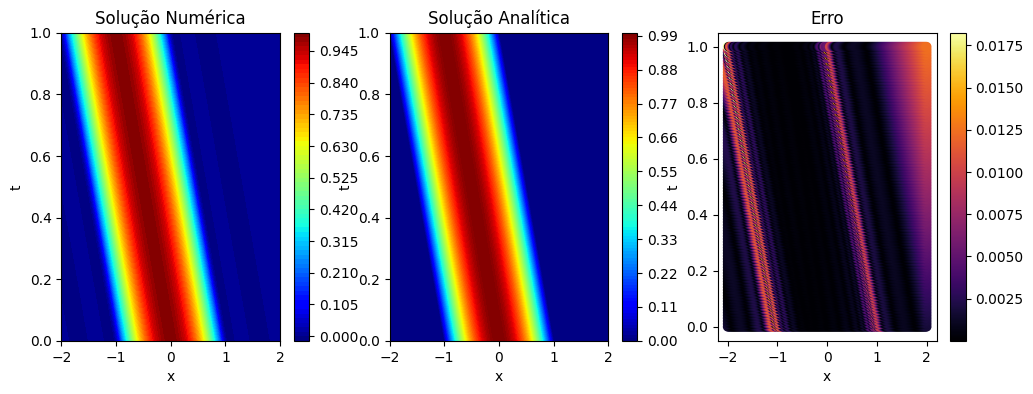

In [ ]:
# Faz o gráfico da solução numérica
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.contourf(x_pred, t_pred, u_pred, 100, cmap='jet')
plt.colorbar()
plt.title('Solução Numérica')
plt.xlabel('x')
plt.ylabel('t')

# Faz o gráfico da solução analítica
plt.subplot(1, 3, 2)
plt.contourf(x_pred, t_pred, u_exact, 100, cmap='jet')
plt.colorbar()
plt.title('Solução Analítica')
plt.xlabel('x')
plt.ylabel('t')

# Faz o gráfico do erro absoluto
plt.subplot(1, 3, 3)
plt.scatter(x_pred, t_pred, c=abserror, cmap='inferno')
plt.colorbar()
plt.title('Erro')
plt.xlabel('x')
plt.ylabel('t')

plt.show()